## Generating new text based on training data with LSTM-networks

### Since this approach will use a bidirectional LSTM-network, the training is twice as slow and requires twice as much memory

## Since textual context depends on both the previous and future words, bidirectional layers are needed to capture the context better.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [ ]:


# MY approach is
# First I try to run examples with different experiments so that I can understand model very well.
# Then I try to change with my own dataset and try to run with simple and without changing anything
# Last point I changed dataset along with different parameters and compare different experiments also anaylise best approaches




In [ ]:
# Increase the size of each word’s vector representation from 100 to 128.
# That could help the model learn better poetic structure, rhyming, or phrase flow.
# model.add(Embedding(total_words, 128, input_length=max_sequence_len - 1))
# Results
# It seems it increased the more training time and there is slightly hiegh risk of overfitting.

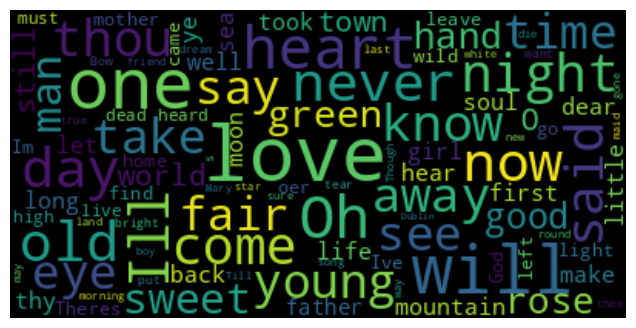

In [ ]:
# Reading the text data file
data = open('/content/poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [ ]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

# the more unique words we have in the corpus
# the heavier our text generation model is going to be to train and use
print("Total Words:", total_words)

Total Words: 3807


In [ ]:
# Converting the text into embeddings (vectorized representations)
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# calculate the longest sequence in the data
max_sequence_len = max([len(x) for x in input_sequences])

# based on the longest sequence (text) in the data
# add extra zeroes to shorter texts so that
# all sequences have equal length (this is called padding)
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


# Define the the bidirectional LSTM-model

In [ ]:
# by changing LSTM(200) from LSTM(100)
# I am expecting these points by changing this value
# More LSTM units should help the model understand words better.
# Poems might sound richer, longer, and make more sense.
# Training might take longer and could overfit a little because the model is bigger.
# Improvements:
# Poems made more sense and stayed on topic longer.
# Used more different words, so less repeating.
# Better at keeping the poetry style.
# Downsides:
# Training took longer because of the increased number of parameters.
# A bit more overfitting — after several epochs, training loss kept dropping but validation loss started rising slightly.
# Overall
# Increasing LSTM units made the poems better and more meaningful. Training took longer and overfitting happened a little,
# but overall, it was a good improvement for poetry

In [ ]:
# Another experiment by changing dropout (model.add(Dropout(0.4))
# Adding more dropout should make the model stronger and poems more varied,
# but training would be slower and there’s a small risk the model might not learn well.
# Results of it
# Dropout helped the model overfit less, made poems less repetitive, and added more variety.
# Training became slower, and in the early stages, the quality of results dropped because too ....
# many were randomly turned off. There's also a risk of underfitting if training doesn't go on long enough.
# Increasing dropout from 0.2 to 0.4 helped the model avoid overfitting and made it more creative. However,
# it made training slower and caused a little drop in quality at first. But with enough training,
# the higher dropout resulted in more diverse and less repetitive poetry, making it a good choice for creative tasks.

In [ ]:
# Building a Bi-Directional LSTM Model
model = Sequential()

# embedding layer, input = total words, output 100 nodes
# this suggests a huge simplifcation of the corpus
# might be a good idea to increase this, however, it also adds
# complexity
model.add(Embedding(total_words + 1, 100,
					input_length=max_sequence_len-1))

# bidirectional LSTM -> to handle context for both ways
# => context of previous words and context of future words
model.add(Bidirectional(LSTM(150, return_sequences=True)))

# some extra layers for optimization
model.add(Dropout(0.2))
model.add(LSTM(100))

# a dense network with reqularization
# SMALL FIX: wrap the amount of nodes into int(), so
# that the division by 2 does not result in decimals
# amount of nodes has to be an even integer
model.add(Dense(int(total_words+1/2), activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))

# output layer -> every possible word has a separate node for
# probability of that word being the next word in the sentence
model.add(Dense(total_words + 1, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])

print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(predictors, label, epochs=50, verbose=1)


Epoch 1/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.0549 - loss: 7.3331
Epoch 2/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.0656 - loss: 6.5117
Epoch 3/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0654 - loss: 6.3165
Epoch 4/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0670 - loss: 6.1935
Epoch 5/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0755 - loss: 6.1351
Epoch 6/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0835 - loss: 6.0102
Epoch 7/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0813 - loss: 5.9641
Epoch 8/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0990 - loss: 5.8408
Epoch 9/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1018 - loss: 5.7453
Epoch 10/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1115 - loss: 5.6276
Epoch 11/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1134 - loss: 5.5665
Epoch 12/150
510/510 ━━━━

# Testing the model to generate some poetry...

In [ ]:
# the starting point of the the model on top of which
# new words are going to be added (similar to prompt in LLMs)
seed_text = "Soul"

# how many words we wish to generate
next_words = 15
ouptut_text = ""

# loop 25 times to create new words to extend
# the original seed text
for _ in range(next_words):
    # convert the current seed text into vectors + padding
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len - 1,
        padding='pre')

    # predict the next most probable word based on current seed text
    predicted = np.argmax(model.predict(token_list,
                                        verbose=0), axis=-1)
    # initalize next word
    output_word = ""

    # find the predicted word in the tokenizer
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    # finally, add the new predicted word into the end of
    # the current seed text
    seed_text += " " + output_word
    print(seed_text)

# print the result generated by the model
print("\n-- THE FINAL OUTPUT --")
print(seed_text)


Soul immortal
Soul immortal shalt
Soul immortal shalt thou
Soul immortal shalt thou awaken
Soul immortal shalt thou awaken lost
Soul immortal shalt thou awaken lost and
Soul immortal shalt thou awaken lost and whats
Soul immortal shalt thou awaken lost and whats your
Soul immortal shalt thou awaken lost and whats your one
Soul immortal shalt thou awaken lost and whats your one wont
Soul immortal shalt thou awaken lost and whats your one wont tried
Soul immortal shalt thou awaken lost and whats your one wont tried to
Soul immortal shalt thou awaken lost and whats your one wont tried to take
Soul immortal shalt thou awaken lost and whats your one wont tried to take your
Soul immortal shalt thou awaken lost and whats your one wont tried to take your hat

-- THE FINAL OUTPUT --
Soul immortal shalt thou awaken lost and whats your one wont tried to take your hat
